In [1]:
from utils import *
%reload_ext autoreload
%autoreload 2

2024-06-04 14:00:46.511343: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-04 14:00:46.514877: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-04 14:00:46.552293: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 14:00:47.776996: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/media/acartes/Windows-SSD/Users/aleja/Desktop/Supernovae Pipeline/Supernovae-Complete-Pipeline/sn_pipeline_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stabl

In [11]:
Ia_class = SN_data(head_file="Lightcurves/curves/Ia/DES/DES_Ia_HEAD.FITS",
                   phot_file="Lightcurves/curves/Ia/DES/DES_Ia_PHOT.FITS")

noIa_class = SN_data(head_file="Lightcurves/curves/nonIa/DES/DES_nonIa_HEAD.FITS",
                     phot_file="Lightcurves/curves/nonIa/DES/DES_nonIa_PHOT.FITS")

for i, sn_class in enumerate([Ia_class, noIa_class]):
    sn_class.reader()
    sn_class.lc_df = sn_class.lc_df[sn_class.lc_df.index < 2_500]

    sn_class.preprocess(z_host=True)
    sn_class.obs_discarded

In [5]:
nn_class = NN_classifier([Ia_class, noIa_class])
nn_class.train_test_split()
nn_class.NN_reshape()
nn_class.model_nl_creator_ph()

<Functional name=3_layer, built=True>

Best f: 0.956 (out of 0 params): |          |  [00:00<?, ...]


Restored search from checkpoint './data_folder/checkpoints/classifier.ckpt'
Search is scheduled for 0 steps
================ Summary ===============
Mode             : Best f : Steps : Time
---------------- : ----   : ----  : ----
---------------- : ----   : ----  : ----
Total            : 0.9557 : 0     : 4 ms
Best params: {'n': 2, 'rnns_i': array([1, 1, 1]), 'neurons': array([32, 32, 32]), 'activations_i': array([1, 1, 1]), 'init_weights_i': array([1, 1, 1]), 'dropout': 0.2, 'lr': 0.0001, 'batch_size': 16}


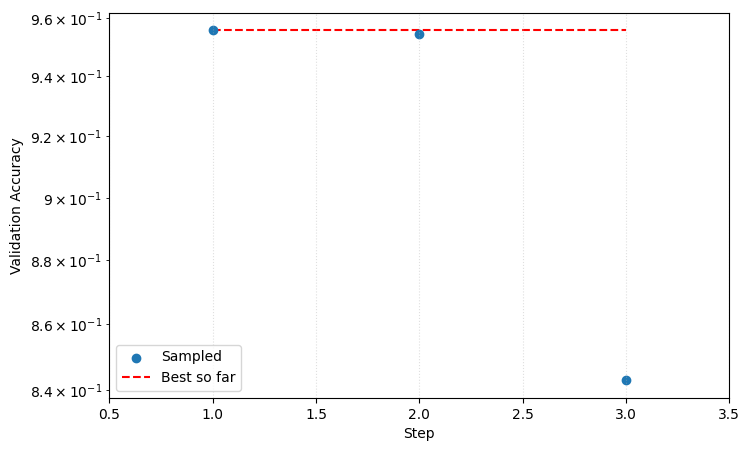

In [6]:
n_max = 3
search_nl = pyhopper.Search(n = pyhopper.int(1, n_max),
                            rnns_i = pyhopper.int(0, 2, shape=n_max),
                            neurons = pyhopper.int(2, 512, power_of=2, shape=n_max),
                            activations_i = pyhopper.int(0, 2, shape=n_max),
                            init_weights_i = pyhopper.int(0, 2, shape=n_max),
                            dropout = pyhopper.float(0, 0.4, precision=2),
                            lr = pyhopper.float(1e-5, 1e-3, log=True, precision=1),
                            batch_size = pyhopper.int(2, 128, power_of=2)
                            )

best_params, batch_size = nn_class.best_hyp_pyhopper(search_nl,
                                                     nn_class.model_nl_creator_ph,
                                                     time='30m',
                                                     save=True, load=True)

In [33]:
nn_class.model_nl_creator_ph(**best_params)
plot_model(nn_class.model,
           to_file=f"data_folder/images/model.pdf",
           show_shapes=True)
nn_class.model_statistics(num_it=5, batch_size=batch_size, patience=25,
                          load=True)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Train set'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Validation set'}, xlabel='Epochs'>],
       dtype=object))

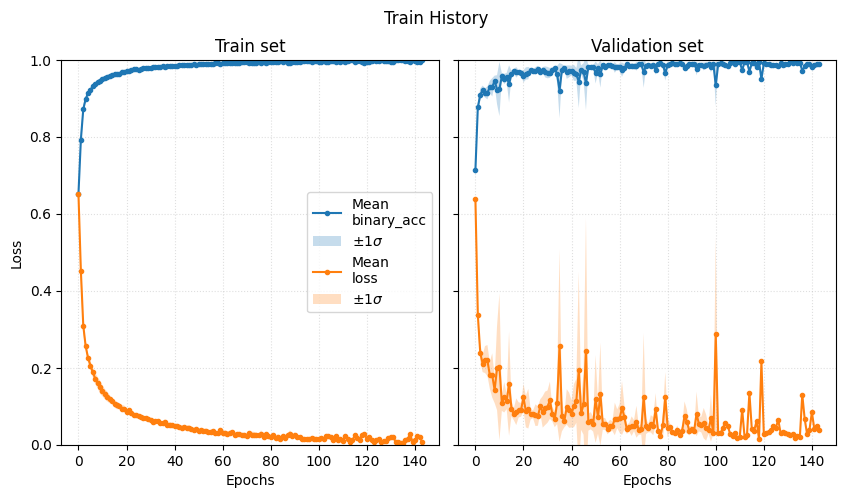

In [34]:
nn_class.training_loss_plot()

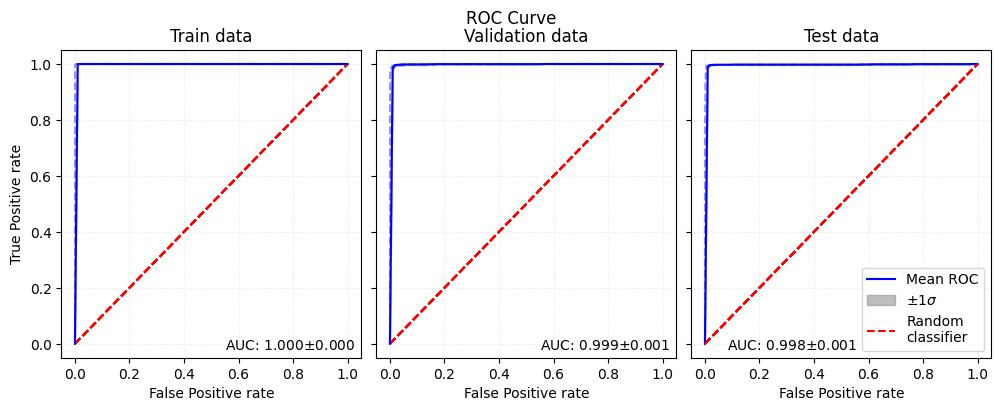

In [35]:
fig, ax = nn_class.plot_roc_curve()

(<Figure size 1500x500 with 6 Axes>,
 array([<Axes: title={'center': 'Train data'}, xlabel='Predicted label', ylabel='True label'>,
        <Axes: title={'center': 'Validation data'}, xlabel='Predicted label'>,
        <Axes: title={'center': 'Test data'}, xlabel='Predicted label'>],
       dtype=object))

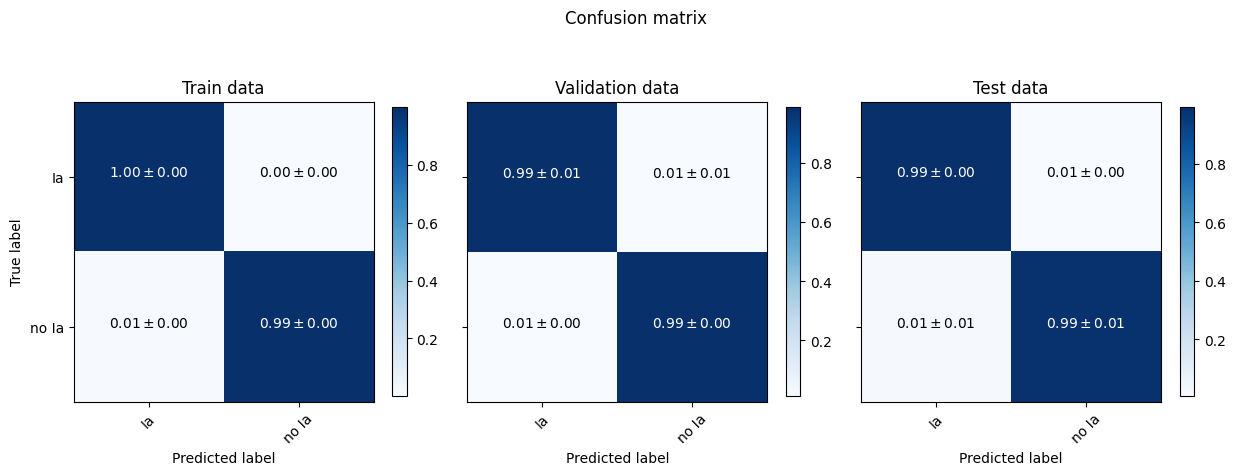

In [36]:
nn_class.plot_confusion_matrix(normalize=True)

# Multi filter

In [2]:
bands = ['g', 'r', 'i', 'z']
combinations=[]

for r in range(1, len(bands) + 1):
    for subset in itertools.combinations(bands, r):
        combinations.append(list(subset))

folder_Ia = "Lightcurves/curves/Ia/DES/SNANA_aug"
folder_noIa = "Lightcurves/curves/nonIa/DES/SNANA_aug"

Ia_classes = []
noIa_classes = []

for comb in combinations:
    file_Ia = folder_Ia + ("/DES_Ia_" + ''.join(comb)) * 2
    head_Ia = file_Ia + "_HEAD.FITS"
    phot_Ia = file_Ia + "_PHOT.FITS"
    Ia_classes.append(SN_data(head_file=head_Ia, phot_file=phot_Ia))

    file_noIa = folder_noIa + ("/DES_noIa_" + ''.join(comb)) * 2
    head_noIa = file_noIa + "_HEAD.FITS"
    phot_noIa = file_noIa + "_PHOT.FITS"
    noIa_classes.append(SN_data(head_file=head_noIa, phot_file=phot_noIa))


classes = np.append(Ia_classes, noIa_classes)
for i, sn_class in enumerate(classes):
    sn_class.reader()
    sn_class.lc_df = sn_class.lc_df[sn_class.lc_df.index < 500]
    sn_class.preprocess(z_host=True)

In [3]:
nn_class_mf = NN_classifier(classes)
nn_class_mf.train_test_split()
nn_class_mf.NN_reshape()
nn_class_mf.model_nl_creator_ph()

<Functional name=3_layer, built=True>

Best f: 0.956 (out of 0 params): |          |  [00:00<?, ...]


Restored search from checkpoint './data_folder/checkpoints/classifier.ckpt'
Search is scheduled for 0 steps
================ Summary ===============
Mode             : Best f : Steps : Time
---------------- : ----   : ----  : ----
---------------- : ----   : ----  : ----
Total            : 0.9557 : 0     : 7 ms
Best params: {'n': 2, 'rnns_i': array([1, 1, 1]), 'neurons': array([32, 32, 32]), 'activations_i': array([1, 1, 1]), 'init_weights_i': array([1, 1, 1]), 'dropout': 0.2, 'lr': 0.0001, 'batch_size': 16}


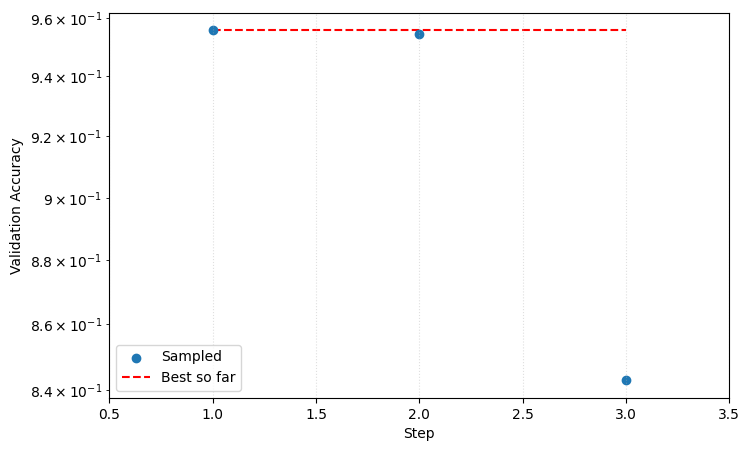

In [5]:
n_max = 3
search_nl = pyhopper.Search(n = pyhopper.int(1, n_max),
                            rnns_i = pyhopper.int(0, 2, shape=n_max),
                            neurons = pyhopper.int(2, 512, power_of=2, shape=n_max),
                            activations_i = pyhopper.int(0, 2, shape=n_max),
                            init_weights_i = pyhopper.int(0, 2, shape=n_max),
                            dropout = pyhopper.float(0, 0.4, precision=2),
                            lr = pyhopper.float(1e-5, 1e-3, log=True, precision=1),
                            batch_size = pyhopper.int(2, 128, power_of=2)
                            )

best_params, batch_size = nn_class_mf.best_hyp_pyhopper(search_nl,
                                                        nn_class_mf.model_nl_creator_ph,
                                                        time='30m',
                                                        save=True, load=True)

In [6]:
nn_class_mf.model_nl_creator_ph(**best_params)
plot_model(nn_class_mf.model,
           to_file=f"data_folder/images/model.pdf",
           show_shapes=True)
nn_class_mf.model_statistics(num_it=3, batch_size=batch_size, patience=25,
                             load=True)

328/328 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Train set'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Validation set'}, xlabel='Epochs'>],
       dtype=object))

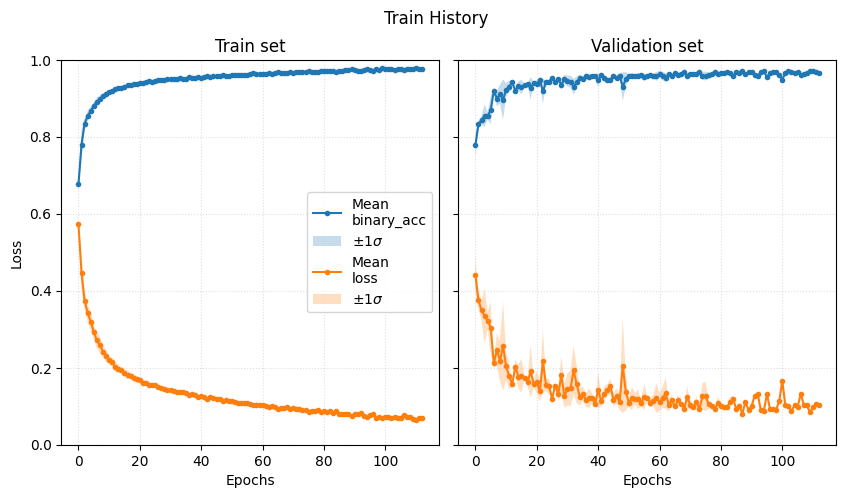

In [7]:
nn_class_mf.training_loss_plot()

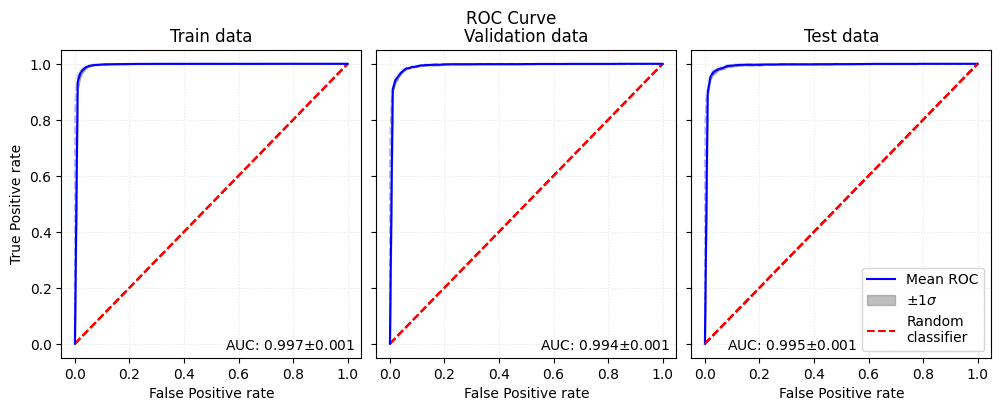

In [8]:
fig, ax = nn_class_mf.plot_roc_curve()

(<Figure size 1500x500 with 6 Axes>,
 array([<Axes: title={'center': 'Train data'}, xlabel='Predicted label', ylabel='True label'>,
        <Axes: title={'center': 'Validation data'}, xlabel='Predicted label'>,
        <Axes: title={'center': 'Test data'}, xlabel='Predicted label'>],
       dtype=object))

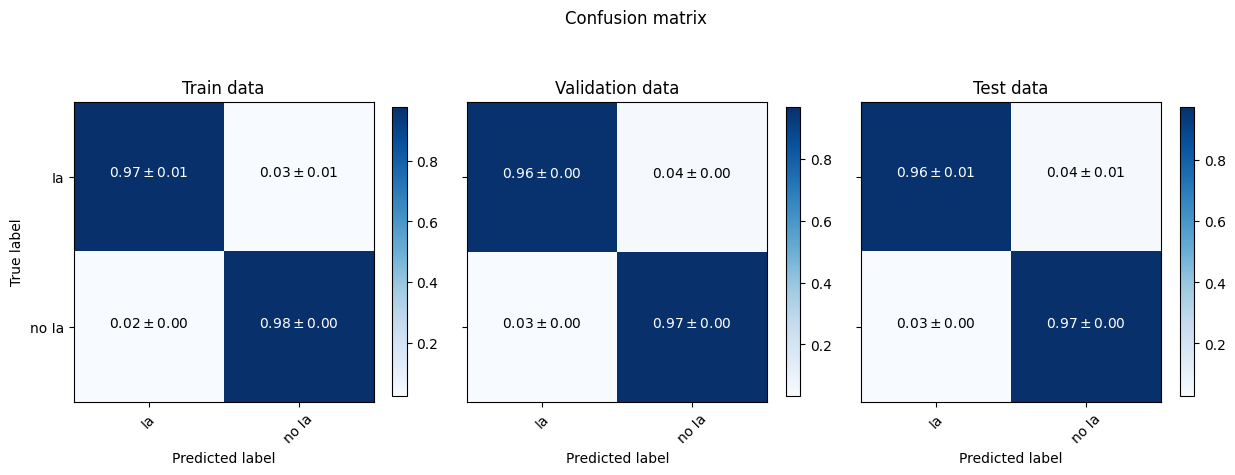

In [9]:
nn_class_mf.plot_confusion_matrix(normalize=True)